In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
# Change...
pair = 'BTCUSDT'
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
interval = '1H'
# date to start/end analysis
dt_start_analysis = '2021-1-1'
# Use '' for analysis until now
dt_end_analysis = ''

# Gathering data

In [36]:
from trade_utils import get_data

data = get_data(pair, interval)

# Target variable

In [37]:
from machine_learning_utils import get_labels_future_returns

data['signal'] = get_labels_future_returns(data[['ClosePrice']].copy())
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,signal
OpenTime,,,,,,
2021-08-03 08:00:00,38593.43,38666.00,38315.00,38523.43,1620.408658,1
2021-08-03 09:00:00,38523.43,38646.39,38340.00,38642.28,1437.974884,1
2021-08-03 10:00:00,38646.44,38809.00,38478.63,38713.13,1658.409297,0
2021-08-03 11:00:00,38713.14,38748.82,38400.00,38490.01,1503.346680,0
2021-08-03 12:00:00,38490.02,38538.37,37703.75,38283.33,5655.152273,0


# Features

In [38]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['Volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['RSI'] = rsi(data['ClosePrice'])

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data['HighPrice'], data['LowPrice'], data['ClosePrice'])

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [39]:
# Drop the missing values
data.dropna(inplace=True)

# Create X and y

In [40]:
# Target
y = data[['signal']].copy()

# Features
X = data[['Returns', 'Returns2', 'Returns5', 'Volatility',
       'SMA5', 'SMA10', 'SMA20', 'SMA30', 'SMA50', 'SMA100', 'SMA200',
       'EMA5', 'EMA10', 'EMA20', 'EMA30', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'MACDSignal', 'MACDHist',
       'RSI', 'DI+', 'DI-', 'ADX',
       'UpperBBand', 'MidiBBand', 'LowerBBand']].copy()

## Sationary check

In [41]:
from machine_learning_utils import is_stationary

# Check for stationarity
for col in X.columns:
    if not is_stationary(data[col]):
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Returns is stationary.
Returns2 is stationary.
Returns5 is stationary.
Volatility is stationary.
SMA5 is not stationary. Dropping it.
SMA10 is not stationary. Dropping it.
SMA20 is not stationary. Dropping it.
SMA30 is not stationary. Dropping it.
SMA50 is not stationary. Dropping it.
SMA100 is not stationary. Dropping it.
SMA200 is not stationary. Dropping it.
EMA5 is not stationary. Dropping it.
EMA10 is not stationary. Dropping it.
EMA20 is not stationary. Dropping it.
EMA30 is not stationary. Dropping it.
EMA50 is not stationary. Dropping it.
EMA100 is not stationary. Dropping it.
EMA200 is not stationary. Dropping it.
MACD is stationary.
MACDSignal is stationary.
MACDHist is stationary.
RSI is stationary.
DI+ is stationary.
DI- is stationary.
ADX is stationary.
UpperBBand is not stationary. Dropping it.
MidiBBand is not stationary. Dropping it.
LowerBBand is not stationary. Dropping it.


## Correlation check

In [42]:
from machine_learning_utils import get_pair_above_threshold

print(get_pair_above_threshold(X, 0.7))

MultiIndex([('MACD', 'MACDSignal'),
            ( 'RSI',        'DI+'),
            ( 'RSI',        'DI-'),
            ( 'DI+',        'DI-')],
           )


In [43]:
# Drop the highly correlated column
X = X.drop(columns=['MACDSignal'], axis=1)
X = X.drop(columns=['DI+'], axis=1)
X = X.drop(columns=['DI-'], axis=1)

In [73]:
X.head()

,Returns,Returns2,Returns5,Volatility,MACD,MACDHist,RSI,ADX
OpenTime,,,,,,,,
2017-08-25 11:00:00,1.088002,0.384619,1.360767,91.792823,41.938005,-0.852229,62.46,26.097672
2017-08-25 12:00:00,-1.182683,-0.107549,-0.446061,91.575955,38.246298,-3.635149,54.58,24.788873
2017-08-25 13:00:00,0.053600,-1.129717,-0.465587,91.601825,35.102353,-5.423275,54.85,23.573560
2017-08-25 14:00:00,-0.162338,-0.108825,-0.910564,87.021565,31.680717,-7.075929,53.79,22.603972
2017-08-25 15:00:00,2.075726,1.910019,1.854981,96.002884,35.767347,-2.391439,63.50,22.304347


# Train-test split

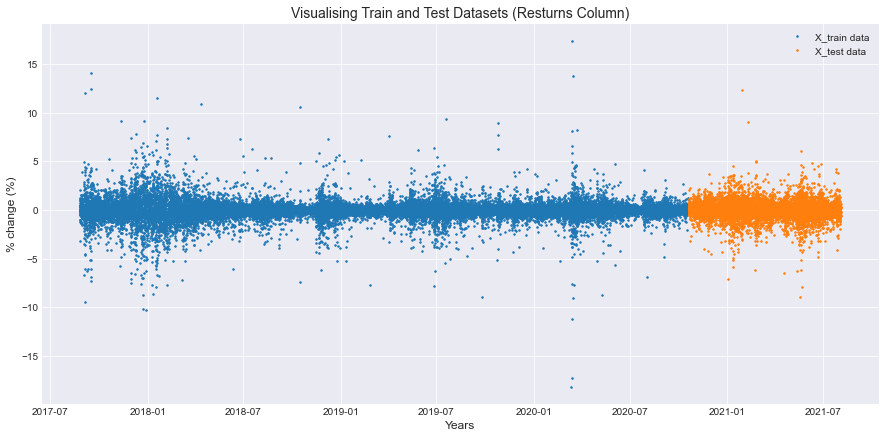

In [74]:
# Obtain the features and target for the 'train_data' and 'test_data' without shuffling
# shuffle is not correct to use in time-series analysis because the order of data is crucial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (Resturns Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

# Machine Learning classification and forecasting

In [75]:
# Create the machine learning model
rf_model = RandomForestClassifier(
    n_estimators=3, max_features=3, max_depth=2, random_state=4)

# Fit the model on the training data
rf_model.fit(X_train, y_train['signal'])

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=3,
                       random_state=4)

## Forecast data

In [86]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,Returns,Returns2,Returns5,Volatility,MACD,MACDHist,RSI,ADX
OpenTime,,,,,,,,
2020-10-20 04:00:00,-0.149647,0.029693,-0.238608,39.274458,63.382222,-5.080631,61.66,48.58984


In [87]:
# Get the prediction of a single day
single_day_prediction = rf_model.predict(unseen_data_single_day)

# Preview the prediction
single_day_prediction

array([1])

In [78]:
# Use the model and predict the values for the test data
y_pred = rf_model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [1 0 0 1 1]


# Metrics

## Accuracy

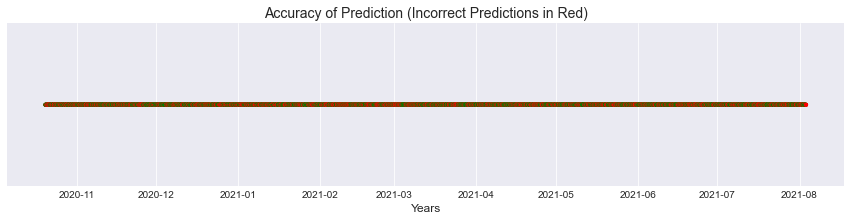

The accuracy is 53.28%.


In [93]:
# Define the accuracy data
y_test_values = y_test['signal'].values
accuracy_data = (y_pred == y_test_values)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

## Confusion Matrix

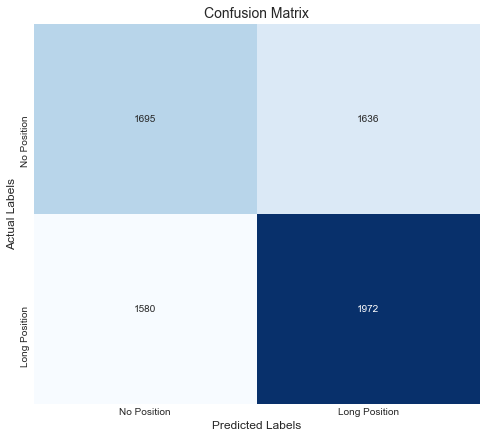

In [94]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test_values, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

# Display the plot
plt.show()

## Classification report

In [95]:
# Classification report
classification_report_data = classification_report(y_test_values, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.52      0.51      0.51      3331
           1       0.55      0.56      0.55      3552

    accuracy                           0.53      6883
   macro avg       0.53      0.53      0.53      6883
weighted avg       0.53      0.53      0.53      6883



# Strategy backtesting

In [103]:
strategy_data = pd.DataFrame(index=y_test.index, columns = ['ClosePrice', 'signal'])
strategy_data['signal'] = y_pred
strategy_data['ClosePrice'] = data.loc[strategy_data.index]['ClosePrice']
strategy_data.head()

,ClosePrice,signal
OpenTime,,
2020-10-20 04:00:00,11723.43,1
2020-10-20 05:00:00,11755.53,0
2020-10-20 06:00:00,11790.06,0
2020-10-20 07:00:00,11735.46,1
2020-10-20 08:00:00,11740.10,1


## Strategy returns

In [105]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['ClosePrice'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,ClosePrice,signal,pct_change,strategy_returns
OpenTime,,,,
2020-10-20 05:00:00,11755.53,0,0.002738,0.002738
2020-10-20 06:00:00,11790.06,0,0.002937,0.000000
2020-10-20 07:00:00,11735.46,1,-0.004631,-0.000000
2020-10-20 08:00:00,11740.10,1,0.000395,0.000395
2020-10-20 09:00:00,11785.19,0,0.003841,0.003841


## Equity Curve

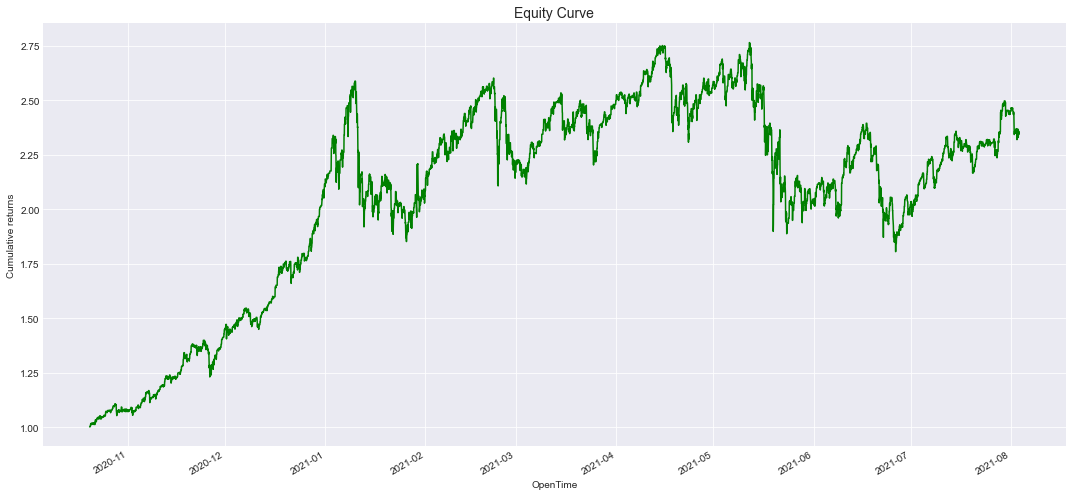

The cumulative return is 134.48%.


In [106]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

In [107]:
# For 1H strategy, year = 8760
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (8760/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 195.87%.


In [108]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    8760) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 70.43%.


The maximum drawdown is -34.68%.


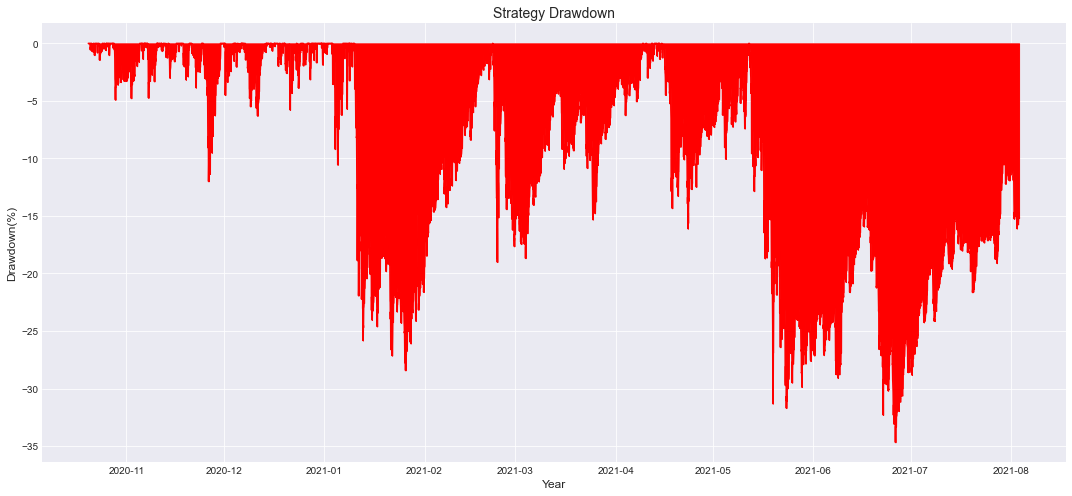

In [109]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [111]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(8760), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 1.89.
